In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from functions.poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

from tqdm.auto import tqdm, trange

## Percent voting people

In [39]:
voter_w = pd.read_csv('dane_years/voters/percent_voters.csv',header=None)

## Stat data

In [3]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [4]:
stat_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:-1]]

In [5]:
for yi in range(len(stat_list)):
    y = files[yi].split('.')[0]
    c = stat_list[yi].columns
    c = [y+'-'+ci for ci in c]
    # c = [y[2:]+'-'+str(ci) for ci in range(len(c))]
    stat_list[yi].columns = c

## Poll data

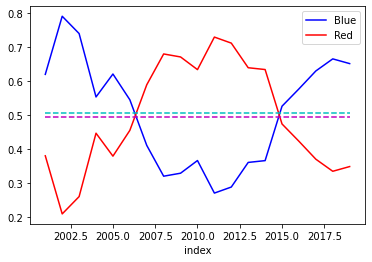

In [6]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/percent_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [7]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [8]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [9]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [10]:
vote_list[0] = vote_list[0].set_index('województwo')

In [11]:
if(False):
    for yi in range(len(vote_list)):
        y = files[yi].split('_WS')[0]
        c = vote_list[yi].columns
        #c = [y+'-'+ci for ci in c]
        # c = [y[2:]+'-'+str(ci) for ci in range(len(c))]
        vote_list[yi].columns = c

        #vote_list[yi] = vote_list[yi].div(vote_list[yi].sum(axis=1), axis=0).fillna(0)

## Neighbours

In [12]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Use 2 approaches to estimate date from years without elections

In [13]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [14]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1]

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [15]:
pool_d = par_in_reg_list if (False) else reg_in_par_list 

In [16]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(pool_data_middle.shape[0]-1):
    # iterate over districts
    tmp_x = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        p = pool_data_middle['Blue'].values[y]
        
        tmp_x.append([lo[0]/lo.sum(), avg_n, p])
    X.append(tmp_x)

In [17]:
X = np.array(X)
X.shape

(18, 16, 3)

## Prepare Y

In [18]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [19]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [20]:
X.shape

(18, 16, 3)

### Models with percentage of Blue support per district

In [37]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x3
    x - vector of input data 18x16x3
    OUTPUT:
    y - predicted value in (0,1)
    '''
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, 3)
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True) ))
    return y

def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x3
    x - vector of input data 18x16x3
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, 3)
    y = y.reshape(-1, 1)
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2 *
          np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) *
          x)
    
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x*a,1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x*a,1,keepdims=True)))**2 *
          np.exp(-np.sum(x*a,1,keepdims=True)) *
          x)
    
    return y1

### Setup for testing model

In [22]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = pool_d[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = pool_d[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

#### Model:

Input| Output
:---|:---
1. output to last election | 1. output of current election
2. avg over neighbours of last election | 
3. global value of polling |

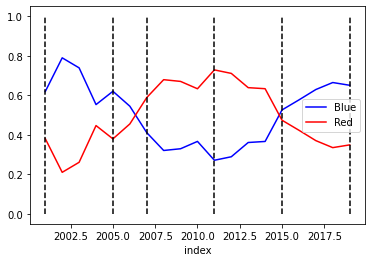

In [23]:
pool_data_middle.plot(color=['b','r'])
for y in [2001,2005,2007,2011,2015,2019]:
    plt.plot([y,y],[0,1], 'k--')
plt.show()

In [24]:
def prepare_input(y, pool=pool_data_middle, year=0):
    tmp_x = np.zeros((y.shape[0],3))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        p = pool['Blue'].values[year]
        
        tmp_x[d] = np.array([y[d,0], avg_n, p])
    return(tmp_x)

In [25]:
def model(a,x,Y,pool=pool_data_middle):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        xi = prepare_input(y,pool,year)
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

## Setup random a

In [26]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
a_nxt = a_avg
a_wgth = a_avg
a_tmp = a_avg

step = 1
beta = 0.01

## Use output -> next input (grad each step)

loss sum: 3.9179710944125405
loss sum: 3.8961110111677604
loss sum: 3.8747510029696763
loss sum: 3.8538709004151666
loss sum: 3.8334516751112346
loss sum: 3.8134753643648023
loss sum: 3.793925001526701
loss sum: 3.7747845515046543
loss sum: 3.7560388510067995
loss sum: 3.7376735531190506


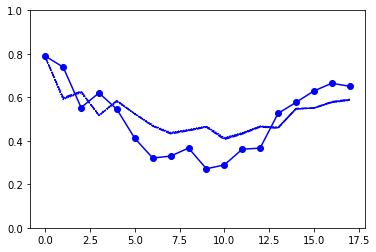

In [60]:
np.random.seed(0)
#a_step = np.random.rand(X.shape[1],X.shape[2])-0.5
step=0.01
for epoch in range(10**3):
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,year=i)
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
        l, o = model(a_step,X,Y)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y)
plt.plot(np.average(o,1, voter_w[1]),'b--')

plt.plot(pool_data_middle['Blue'].values[1:],'bo-')    
plt.ylim(0,1)
plt.show()

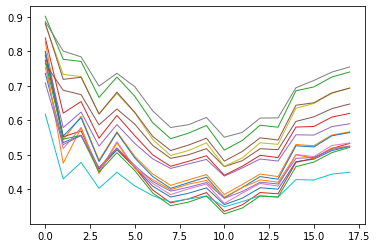

In [59]:
l, o = model(a_step,X,Y)
plt.plot(o.reshape(18,16), linewidth=1)
plt.show()

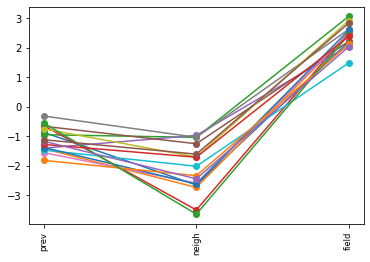

In [61]:
plt.plot(a_step.T, 'o-')
plt.xticks(range(a_step.shape[1]), ['prev','neigh','field'], size='small',rotation=90)
plt.show()

## Use output -> next input (grad each epoch)

loss sum: 9.84542987465292
loss sum: 7.477476221621713
loss sum: 6.648387014344692
loss sum: 6.287852841505643
loss sum: 6.127412169626341
loss sum: 6.060863300189537
loss sum: 6.037651119199043
loss sum: 6.032437185116109
loss sum: 6.033112384050457
loss sum: 6.0345906471990585


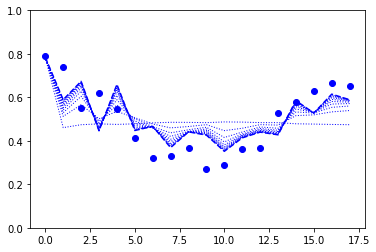

In [49]:
# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
#fig, ax = plt.subplots(nrows=2, ncols=2)

loss_l = np.inf
a_nxt = np.random.rand(X.shape[1],X.shape[2])-0.5
step = 0.01

for epoch in range(10**3):
    loss_p = 0
    y = Y[0]
    grad = np.zeros(X[0].shape)
    
    for i in range(1,X.shape[0]):
        xi = prepare_input(y,year=i)
        y = model_percent(a_nxt,xi)
        grad += grad_percent(a_nxt,xi,Y[i])
        loss_p += np.sum((model_percent(a_nxt,xi) - Y[i].reshape(-1,1))**2)
    
    grad = np.sum(grad, axis=0)
    
    #if loss_p > loss_l: 
    #    print('loss sum:',loss_p)
    #    break
    a_nxt = a_nxt - step*grad
    loss_l = loss_p
    
    if epoch%100==0: 
        print('loss sum:',loss_p)
        n = epoch//(10)
        l, o = model(a_nxt,X,Y)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)
        '''
        if(n<9):
            l, o = model(a_nxt,X,Y)
            ax[n//2,n%2].plot(np.mean(o,1),'b--')
            ax[n//2,n%2].plot(pool_data_middle['Blue'].values[1:],'b')
            ax[n//2,n%2].set_ylim(0,1)
        '''
l, o = model(a_nxt,X,Y)

plt.plot(np.average(o,1, voter_w[1]),'b--')
plt.plot(pool_data_middle['Blue'].values[1:],'bo')
plt.ylim(0,1)

plt.show()


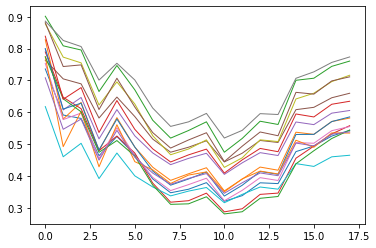

In [50]:
l, o = model(a_step,X,Y)
plt.plot(o.reshape(18,16), linewidth=1)
plt.show()

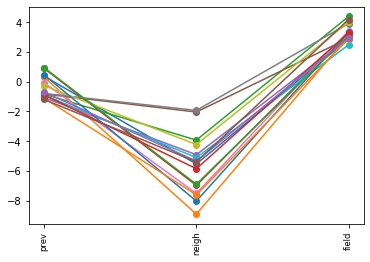

In [46]:
plt.plot(a_step.T, 'o-')
plt.xticks(range(a_step.shape[1]), ['prev','neigh','field'], size='small',rotation=90)
plt.show()